In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import matplotlib as mpl

In [56]:
#load the first sheet of aggregationV3
df12=pd.read_csv("../AggregationV4.csv")
df12=df12[:].copy()

df13=pd.read_csv("../AggregationV4_13CO.csv")
df13=df13[:].copy()

## remake Fig 10, 13CO 12CO properties vs Rgal 

In [57]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.grid.which':

In [58]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["ytick.labelsize"]=16
plt.rcParams["xtick.labelsize"]=16


### retain only necessary fields 

In [59]:
df12_cut=df12[["CLOUDNUM","RGAL_KPC","FLUX_KKMS_PC2","FLUX_NOEX","SIGV_KMS"]]

In [60]:
df12_cut=df12_cut.rename(columns={"FLUX_KKMS_PC2": "FLUX_KKMS_PC2_12CO",\
                                  "FLUX_NOEX":"FLUX_NOEX_12CO","SIGV_KMS":"SIGV_12CO"})
df12_cut

,CLOUDNUM,RGAL_KPC,FLUX_KKMS_PC2_12CO,FLUX_NOEX_12CO,SIGV_12CO
0,2,2.437271,4017.990011,2940.588034,2.383785
1,3,2.951875,679.957543,289.659221,1.290904
2,4,2.219687,6711.284544,5219.570374,3.138678
3,5,2.474493,15511.107190,13686.789270,2.097412
4,6,2.700979,1197.355086,1197.355086,1.035699
...,...,...,...,...,...
439,441,1.948576,225.143998,207.432841,0.262894
440,442,2.276506,1430.370898,869.254455,0.766049
441,443,2.842730,1277.002958,914.236654,0.425937
442,444,2.395559,3849.098462,2414.520647,2.009747


In [61]:
df13_cut=df13[["CLOUDNUM","RGAL_KPC","FLUX_KKMS_PC2","FLUX_NOEX","SIGV_KMS"]]

In [62]:
df13_cut=df13_cut.rename(columns={"FLUX_KKMS_PC2": "FLUX_KKMS_PC2_13CO",\
                                  "FLUX_NOEX":"FLUX_NOEX_13CO","SIGV_KMS":"SIGV_13CO"})

### cross-match two datasets

In [63]:
df_both=pd.merge(df13_cut, df12_cut, on='CLOUDNUM', how='inner')
# df_both

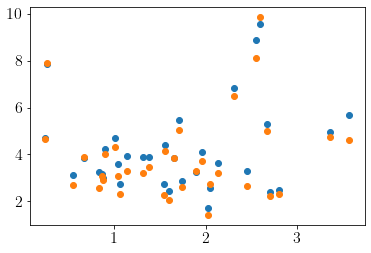

In [64]:
plt.scatter(df_both["RGAL_KPC_x"],df_both["SIGV_12CO"])
plt.scatter(df_both["RGAL_KPC_x"],df_both["SIGV_13CO"])

# plt.xlim(0,4)
# plt.ylim(0,20)

(0.0, 20.0)

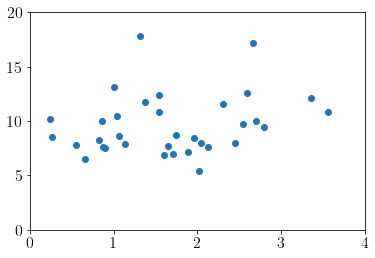

In [65]:
plt.scatter(df_both["RGAL_KPC_x"],df_both["FLUX_KKMS_PC2_12CO"]/df_both["FLUX_KKMS_PC2_13CO"])
plt.xlim(0,4)
plt.ylim(0,20)

In [66]:
x=np.copy(df_both["RGAL_KPC_x"])
y=np.copy(df_both["FLUX_KKMS_PC2_12CO"]/df_both["FLUX_KKMS_PC2_13CO"])

### fit a model: linear relation with Gaussian intrinsic scatter $\sigma$, likelihood function:

$$L(d|m,b,\sigma)=\Pi_i \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left[-\frac{(y_i-mx_i-b)^2}{2\sigma^2}\right]$$

In [67]:
def log_likelihood(theta, x, y):
    m, b, sigma = theta
    model = m * x + b
    sigma2 =  sigma**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


Maximum likelihood estimates:
m = 0.749
b = 8.376
sigma = 2.659


Text(0, 0.5, '$\\mathrm{^{12}CO/^{13}CO \\ line \\ ratio}$')

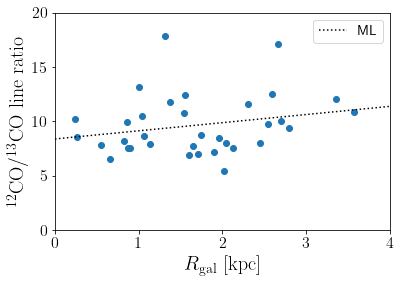

In [68]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0, 10, 2]) + 0.1 * np.random.randn(3)

x=np.copy(df_both["RGAL_KPC_x"])
y=np.copy(df_both["FLUX_KKMS_PC2_12CO"]/df_both["FLUX_KKMS_PC2_13CO"])
yerr=np.zeros_like(y)
soln = minimize(nll, initial, args=(x, y))
m_ml, b_ml, sigma_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("sigma = {0:.3f}".format(sigma_ml))

plt.scatter(x,y)
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
x0=np.linspace(0, 4, 20)

plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0,4)
plt.ylim(0,20)
plt.xlabel("$R_{\mathrm{gal}}~[\mathrm{kpc}]$")
plt.ylabel("$\mathrm{^{12}CO/^{13}CO \ line \ ratio}$")

In [69]:
import emcee

In [70]:
def log_prior(theta):
    m, b, sigma = theta
    if -5.0 < m < 5 and 0.0 < b < 20.0 and 0 < sigma < 20:
        return 0.0
    return -np.inf

In [71]:
def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

In [72]:
soln.x

array([0.74877713, 8.37556478, 2.65865164])

In [73]:
pos = soln.x * (1 + 0.1 * np.random.randn(32, 3))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y)
)
sampler.run_mcmc(pos, 50000, progress=True);



100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:36<00:00, 1374.70it/s]


In [74]:
flat_samples = sampler.get_chain(discard=10000, thin=15, flat=True)
print(flat_samples.shape)

(85312, 3)


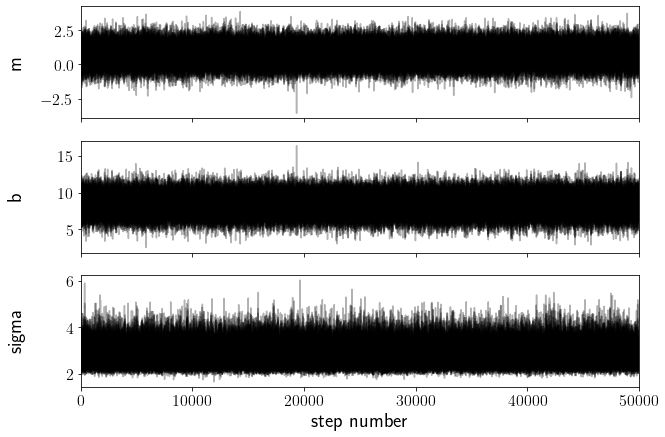

In [75]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

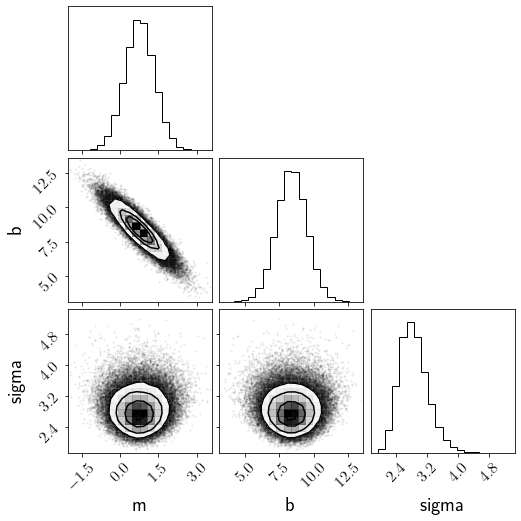

In [76]:
import corner

fig = corner.corner(
    flat_samples, labels=labels,
);

In [86]:
for i in range(3):
    print(np.percentile(flat_samples[:,i],16)-np.percentile(flat_samples[:,i],50),np.percentile(flat_samples[:,i],84)-np.percentile(flat_samples[:,i],50))

i=0
m_best=np.percentile(flat_samples[:,i],50)
m_m=np.percentile(flat_samples[:,i],16)-np.percentile(flat_samples[:,i],50)
m_p=np.percentile(flat_samples[:,i],84)-np.percentile(flat_samples[:,i],50)
i=1
b_best=np.percentile(flat_samples[:,i],50)
b_m=np.percentile(flat_samples[:,i],16)-np.percentile(flat_samples[:,i],50)
b_p=np.percentile(flat_samples[:,i],84)-np.percentile(flat_samples[:,i],50)
i=2
sig_best=np.percentile(flat_samples[:,i],50)
sig_m=np.percentile(flat_samples[:,i],16)-np.percentile(flat_samples[:,i],50)
sig_p=np.percentile(flat_samples[:,i],84)-np.percentile(flat_samples[:,i],50)

-0.5810043690506344 0.5771014053368998
-1.0825063444099285 1.0889579743813513
-0.3247405874127862 0.3967575301752264


In [87]:
print(np.percentile(flat_samples[:,0],16),np.percentile(flat_samples[:,0],50), np.percentile(flat_samples[:,0],84))
print(np.percentile(flat_samples[:,1],16),np.percentile(flat_samples[:,1],50), np.percentile(flat_samples[:,1],84))
print(np.percentile(flat_samples[:,2],16),np.percentile(flat_samples[:,2],50), np.percentile(flat_samples[:,2],84))

0.16908253407539334 0.7500869031260277 1.3271883084629275
7.28777654605307 8.370282890462999 9.45924086484435
2.4927602365518826 2.817500823964669 3.2142583541398952


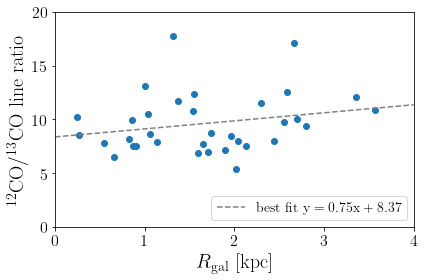

In [88]:
plt.figure(figsize=(6,4))
plt.scatter(x,y)
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), "--", c="grey",\
         label=r"$\rm best\ fit\ y={:.2f}x+{:.2f}$".format(m_best,b_best))
plt.legend(fontsize=14,loc='lower right')
plt.xlim(0,4)
plt.ylim(0,20)
plt.xlabel("$R_{\mathrm{gal}}~[\mathrm{kpc}]$")
plt.ylabel("$\mathrm{^{12}CO/^{13}CO \ line \ ratio}$")
plt.tight_layout()
plt.savefig("fit_lineR_Rgal.pdf")

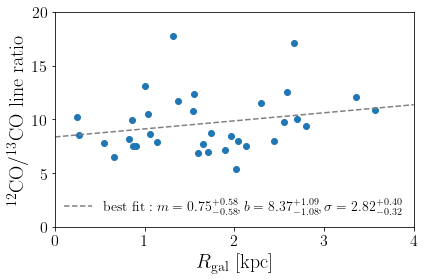

In [92]:
plt.figure(figsize=(6,4))
plt.scatter(x,y)
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), "--", c="grey",\
         label=r"$\mathrm{{ best\ fit}}: m={:.2f}^{{+{:.2f}}}_{{{:.2f}}}, b={:.2f}^{{+{:.2f}}}_{{{:.2f}}}, \sigma={:.2f}^{{+{:.2f}}}_{{{:.2f}}}$".format(\
                                                                                            m_best,m_p,m_m,b_best,b_p,b_m,sig_best,sig_p,sig_m))
# plt.annotate(r"$m=0.74^{+0.58}_{-0.57}$",(0,0))
plt.legend(fontsize=14,loc='lower right',frameon=False)
plt.xlim(0,4)
plt.ylim(0,20)
plt.xlabel("$R_{\mathrm{gal}}~[\mathrm{kpc}]$")
plt.ylabel("$\mathrm{^{12}CO/^{13}CO \ line \ ratio}$")
plt.tight_layout()
plt.savefig("fit_lineR_Rgal_param.pdf")